In [1]:
import pickle
import pandas as pd
import logging
from IPython.display import display
logging_format = '%(asctime)s %(levelname)s: %(message)s'
logging.basicConfig(format=logging_format, datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)
import shap
shap.initjs()

# SHAP VALUES

Se eligen las *__shap-values__* como métricas de interpretación por su facilidad de dar a conocer la importancia de las características en las predicciones del modelo, esto de manera global o individual.

Se cargan la data y objetos necesarios.

In [2]:
data_path = 'explainer.sav'
explainer = pickle.load(open(data_path, 'rb'))

data_path = 'shap_values.sav'
shap_values = pickle.load(open(data_path, 'rb'))

data_path = 'X_test_p.sav'
X_test_p = pickle.load(open(data_path, 'rb'))

data_path = 'X_test_pd.sav'
X_test_pd = pickle.load(open(data_path, 'rb'))

data_path = 'y_test.sav'
y_test = pickle.load(open(data_path, 'rb'))

data_path = 'y_pred.sav'
y_pred = pickle.load(open(data_path, 'rb'))

In [3]:
data_path = 'final_data_test_complete.sav'
data_test = pickle.load(open(data_path, 'rb'))
movie_with_cluster = pickle.load(open('movie_with_cluster.sav',
                                      'rb'))
data_test = pd.merge(data_test,
                     movie_with_cluster,
                     how="left",
                     on=["movieId"])

A continuación se harán algunos comentarios acerca de la importancia de las características.

## Influencia global

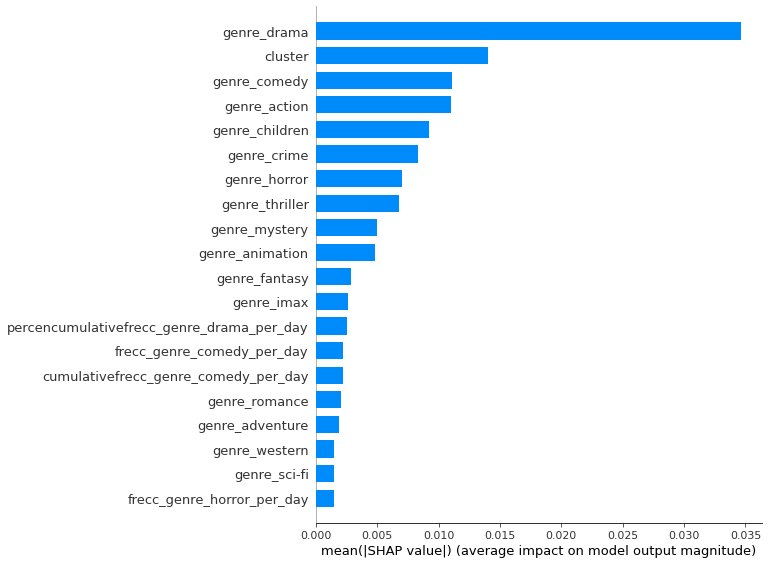

In [4]:
shap.summary_plot(shap_values,
                  features=X_test_pd,
                  feature_names=X_test_pd.columns,
                  plot_type="bar")

COMENTARIOS CON RESPECTO AL PLOT: 
1. El modelo otorga demasiada importancia a las características de las películas. Las primeras 12 posiciones se refieren a que si pertencen o no a cierto tipo de género o grupo de películas. Pero, por si sola, `genre_drama`, es decir, si la película es o no de género `drama`, es la que aporta con mayor contundencia a la probabilidades de `high_rating`, aunque, hasta este gráfico, no se sabe hacia qué dirección.
2. Ninguna característica de usuario está en los primeros lugares de importancia. Eso quiere decir que nuestras características para codificar al usuario no tienen suficiente poder predictivo y se necesita con urgencia poder construir y diseñar más. La característica de usuario más importante tiene que ver precisamente con el género `drama`, es decir, `percencumulativefrecc_genre_drama_per_day`.

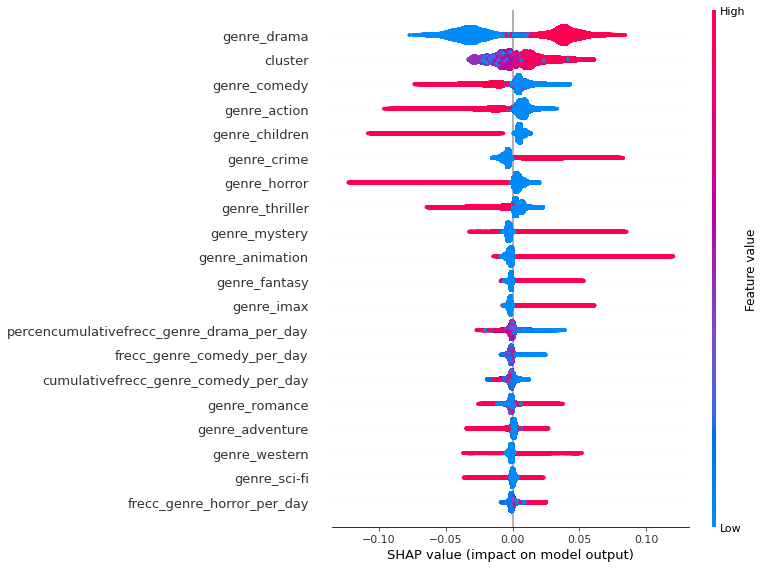

In [5]:
shap.summary_plot(shap_values,                   
                  features=X_test_p,
                  feature_names=X_test_pd.columns)

COMENTARIOS CON RESPECTO AL PLOT:

Es más revelador este gráfico, por que nos da la dirección del valor de las características y hacia dónde se mueve la probabilidad de recomendar.
1. A "mayores valores" de `genre_drama` (solo toma cero o uno) entonces los shap-values serán más grandes y, por ende, mayores serán las probabilidades de tener un *high_rating*. Es decir, por el simple hecho de que la película sea *de drama* ya incide en una mayor probabilidad de que se otorgue una *high_rating*.
2. A mayores valores de cluster, mayores probabilidades de otorgar un *high_rating*. Esto es interesante porque faltaría revisar qué tipo de películas integran los clusters más frecuentes. 
3. Si la película es de alguno de los siguientes géneros: `comedy`, `action`, `children`, `horror` o `thriller`, ese hecho ya de por si incide en bajas probabilidades de otorgar un `high_rating`.
4. Si la película es de alguno de los siguientes géneros: `crime`, `mistery`, `animation`, `fantasy` o `imax`, ese hecho ya de por si incide en probabilidades más grandes de otorgar un `high_rating`.
5. En cuanto al usuario, valores más bajos de `percencumulativefrecc_genre_drama_per_day` incide en probabilidades más grandes de otorgar un `high_rating`. Esto se puede interpretar como que el usuario es capaz de otorgar `high_rating` a otro generos independientemente de que sean de drama o no.

Análicemos la importancia de las características en un caso inidividual.

## Influencia en un caso individual

In [6]:
i=3
data_ind = pd.DataFrame(data_test.loc[3,:]).T
data_ind[['userId', 'movieId', 'rating', 'high_rating', 'title', 'genres', 'cluster', 'percencumulativefrecc_genre_war_per_day']]

,userId,movieId,rating,high_rating,title,genres,cluster,percencumulativefrecc_genre_war_per_day
3,107073,527,5.0,1,Schindler's List (1993),Drama|War,10,0.04878


En este ejemplo, la persona dio una `rating` alto a una película de género drama-war.

In [7]:
logging.info(f'HIGH RATING PREDICHA HECHA POR EL MODELO: {y_pred[i]}')
logging.info(f'HIGH RATING REAL: {y_test[i]}')

2021-11-29 08:10:41 INFO: HIGH RATING PREDICHA HECHA POR EL MODELO: 1
2021-11-29 08:10:41 INFO: HIGH RATING REAL: 1


En este caso, el modelo acertó en predecir el `high_rating`.

Veamos el aporte de las características a esta predicción.

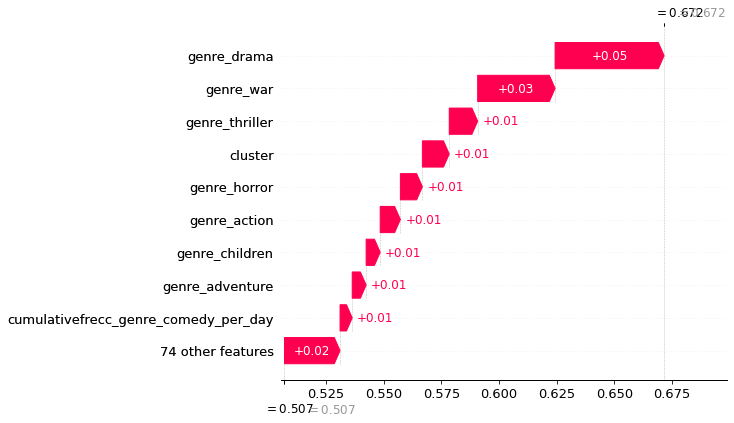

In [8]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value,
                                       shap_values[i],
                                       feature_names=X_test_pd.columns)

Para este primer gráfico, como era de esperarse, el que sea `dramma` ya tiene un aporte positivo grande. Sin embargo, `genre_war`, que no figura en las grandes características influyentes de manera global, se hace presente con el segundo aporte positivo de importancia. La mayoría de la características está aportando positivamente a la probabilidad.

In [9]:
shap.force_plot(explainer.expected_value,
                shap_values[i],
                X_test_p[i],
                feature_names=X_test_pd.columns)

En este segundo plot, se exhibe la *probabilidad predicha*, es decir, 0.67. Se puede observar que existen características que sí aportan negativamente a la probabilidad, como `genre_crimme` o `genre_mistery`, los cuales tienen un impacto global, pero aquí, este aporte negativo es bastante pequeño.

# RESUMEN

* Se abordó un problema de naturaleza tal como para ser tratado con un Sistema de Recomendación de Filtrado Colaborativo desde un punto de vista diferente, es decir, utilizando Aprendizaje Supervisado.
* Con base en el supuesto de que se conoce el listado completo de películas para las cuales los usuarios, tanto nuevos como conocidos, van a otorgar un *rating*, se utiliza un `cluster` de ellas para poder colapsar la información de usuarios y poder trabajar con un conjunto de datos "razonablemente representativo" sin recurrir a herramientas para manejo de big data.
* Se llevo a cabo una ingeniería de característcas para codificar tanto al __usuario__ como a las __películas__ a las que da revisión. Se aprovechó, en el caso de las películas, la información de los géneros en los que ella cae, y en el caso de los __usuarios__, su historial de revisiones a través del tiempo.
* Se usó `xgboost`, curvas de aprendizaje y optimización bayesiana para poder elegir hiperparámetros razonables, aunque el proceso de optimización solo se llevo a cabo en 10 iteraciones de búsqueda.
* El modelo tiene un rendimiento regular con métrica PR-AUC de  Cross-Validation de 0.6072. 
* El modelo exhibe como características más influyentes a `genre_drama` y a `cluster`. La ingeniería de características que se llevó a cabo para codificar usuarios no tiene un aporte contundente en las predicciones. Hace falta revisar su construcción, rediseñar, o diseñar más características.

# PRÓXIMOS PASOS

1. Aumentar el número de clusters que se usan para eliminar la redundancia. Tal vez se está rediciendo demasiado y, por ende, la riqueza de la data no puede ser explotada de manera razonable. Al fin y al cabo, se trata de millones de revisiones de películas que debemos aprovechar.

2. Utilizar la información de los `tags`, más bien de sus conteos e historial através del tiempo para cierto usuario. Se exhibe la información que se logró construir pero no se llegó a incluir en la ingeniería para codificar al usuario.

In [10]:
data_path='tags_info.sav'
tags_info = pickle.load(open(data_path, 'rb'))
tags_info

,userId,movieId,tag_count,min_tag_time_day,max_tag_time_day
128107,102853,115149,1,2015-03-31,2015-03-31
55910,46072,3409,1,2015-03-31,2015-03-31
55920,46072,6058,1,2015-03-31,2015-03-31
148042,123297,562,1,2015-03-30,2015-03-30
148226,123297,1040,1,2015-03-30,2015-03-30
...,...,...,...,...,...
126169,100371,1206,1,2005-12-24,2005-12-24
126168,100371,1193,1,2005-12-24,2005-12-24
126167,100371,47,2,2005-12-24,2005-12-24
126166,100371,32,1,2005-12-24,2005-12-24


Como se puede ver, esta información puede enriquecer el aporte de nuevas características para el usuario. Debido a que hay tags que se siguen poniendo incluso después de haber ya dado un `rating`. Es de sumo cuidado utilizar esta información y se recomienda vincular al `time_day` actual la información de tags que viene de un tiempo inmediato anterior.

También puede influir en la ingeniería para las películas.

3. Utilizar la información implicita de los `tags`. Por ejemplo, con ayuda de Preprocesamiento de Lenguaje Natural se han podido extraer __`tokens`__ para cada película, es decir, palabras clave con información relevante. 

In [11]:
data_path='token_count.sav'
tokens = pickle.load(open(data_path, 'rb'))
data_path='tokens_movies.sav'
tokens_movies = pickle.load(open(data_path, 'rb'))
display(tokens)
display(tokens_movies)

,token,count
0,r,3190
1,bd,2710
2,nudity,2217
3,dvd,1912
4,based,1895
...,...,...
23274,heyn,1
23275,krulik,1
23276,caprino,1
23277,pál,1


,movieId,tag_tokens
0,4141,"[waters, jr, freddie, mark, prinze, naive]"
1,208,"[kevin, stupid, smeat, sci, horrible, alone, m..."
2,353,"[nudity, memories, violence, clv, bittersweet,..."
3,521,"[nudity, noir, police, gary, murder, corruptio..."
4,592,"[realistic, clv, begins, batman, stylized, jac..."
...,...,...
19540,103010,"[friendship, mourning, bittersweet, roadtrip]"
19541,113536,"[political, spy, corruption, thriller]"
19542,113539,"[history, mother, son, book, based, colonialis..."
19543,115373,"[mother, alcoholism, bourgoin, louise, single,..."


Incluirlas podría enriquecer más la ingeniería de las películas al preguntarse cuántos tokens van acumulando las películas hasta cierto tiempo. O bien, a la ingeniería para los usuarios, al preguntarse si ha aportado algún tipo de token en el pasado y para qué tipo de película.